# Um Modelo Preditivo Para Classificação de Risco de Mortalidade de Pacientes com COVID-19 no Rio Grande do Sul

Durante a pandemia de COVID-19 os sistemas de saúde do mundo inteiro enfrentam problemas sem precedentes quanto a disponibilidade e alocação de recursos comorespiradores e leitos de UTI.  Estudos mostram que modelos de aprendizagem de máquina (*machine learning*) conseguem classificar chances de recuperação ou risco de óbito com até 94% de acurácia e 0.74 de pontuação ROC (*Receiver Operating Charachteristic Curve) - AUC (Area Under the Curve*) parapredição de admissão em UTI , contribuindo para amenizar alguns dos problemas relacionados a alocação de recursos.

Os modelos de predição enfrentam pelo menos dois desafios significativos. O primeiro deles diz respeito à limpeza dos dados, isto é, eliminar erros, inconsistências ou pontos fora da curva (outliers, em inglês). O segundo desafio é encontrar modelos, características e métricas de avaliação de algoritmos de aprendizagem de máquina que garantam a credibilidade dos modelos preditivos. Com uma menção honrosa ao desafio de dispor dados para que todas as análises possam ser feitas.

O objetivo desse trabalho é propor um modelo preditivo para classificação de risco de mortalidade de pacientes com COVID-19 no estado do Rio Grande do Sul. Para atingir o objetivo, o trabalho foi dividido em duas etapas. A primeira consiste na limpeza dos dados, e a segunda é propor e validar o uso de técnicas de aprendizagem de máquina para auxiliar na tomada de decisões.




## 0. Carregamento das bibliotecas

In [2]:
# pacotes padrao
import math

# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# Lidando com Warnings 
import warnings
warnings.filterwarnings('ignore')

# plotagem Inline
%matplotlib inline

## 1. Aquisição dos dados

Os dados para a análise, no presente projeto, vêm do [Painel Corona Vírus RS](https://ti.saude.rs.gov.br/covid19/), e compreende o perído de 29/02/2020 a 11/03/2021. Essa plataforma, por sua vez, usa como fontes os dois sistemas de notificações oficiais do Ministério da Saúde no monitoramento da doença: o e-SUS Notifica e o Sistema de Informação da Vigilância Epidemiológica da Gripe (Sivep-Gripe). 

O e-SUS Notifica (que antes era chamado de e-SUS VE) é a ferramenta na qual são notificados os casos de síndrome gripal (SG) que não precisam de internação hospitalar. Casos de SG atendidos em Unidades Sentinelas são notificados no SIVEP-Gripe (Síndrome Gripal). Nos casos em que a pessoa apresenta quadro mais grave da infecção (Síndrome Respiratória Aguda Grave – SRAG) e é necessária a hospitalização, a notificação é feita no SIVEP-Gripe (SRAG Hospitalizado)..

Ambos os sistemas são utilizados pelos serviços de saúde públicos e privados e pelas secretarias municipais de saúde para realização das notificações e monitoramento dos casos e seus contactantes (sintomas, exames realizados, resultados, evolução, entre outros).

In [3]:
df = pd.read_csv("files/20210311.csv", sep=';')

___
## 2. Análise exploratória de Dados - Univariada

Quando exploramos nossos conjunto de dados, temos várias opções. Nós podemos explorar cada caracteristica (*feature*) individualmente, comparar em pares de *features* ou até mesmo abordar a complexidade resultante da multiplicidade das variáveis. Vamos começar com uma análise Univariada (uma variável).

Para o primeiro entendimento dos dados que farão parte da solução proposta, precisamos utilizar de métodos que nos ajudem a vislumbrar seus padrões, "formas" e inclusive pontos fora da curva. Antes de seguirmos para as devidas limpezas ou extrações, vamos utilizar das bibliotecas para análise e visualização de dados do Python, Pandas, Numpy, Matplotlib e Seaborn para nos ajudar a entender o contexto das mesmas.

#### 2.1 Dimensionalidade

In [4]:
print("DIMENSÕES DO DATAFRAME:")
print(f"Linhas:\t\t{df.shape[0]}")
print(f"Colunas:\t{df.shape[1]}")

DIMENSÕES DO DATAFRAME:
Linhas:		713614
Colunas:	29


O conjunto original dos dados, contém 29 dados sobre cada paciente, incluindo dados demograficos e fisiológicos.

#### 2.2 Visualização das 5 primeiras entradas e da descrição dos dados

Visualizar primeiras 5 entradas desse conjunto de dados permitem adquirirmos uma noção inicial sobre o tipo de formato, exemplos de entrada e formulação das hipóteses iniciais do processo investigativo.

In [5]:
df.head()

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,...,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
0,430003,ACEGUÁ,16,BAGE - R22,Feminino,40 a 49,RT-PCR,05/10/2020,29/09/2020,NaN,...,NaN,13/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
1,430003,ACEGUÁ,16,BAGE - R22,Masculino,15 a 19,RT-PCR,06/10/2020,06/10/2020,NaN,...,NaN,20/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
2,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,TESTE RÁPIDO,19/10/2020,05/10/2020,NaN,...,NaN,19/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
3,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,RT-PCR,26/11/2020,18/11/2020,01/12/2020,...,NaN,NaN,BRANCA,NAO ENCONTRADO,NAO INFORMADO,ASSENTAMENTO,SIM,SIVEP HOSP,BRASIL,NAO
4,430003,ACEGUÁ,16,BAGE - R22,Feminino,40 a 49,RT-PCR,09/12/2020,01/12/2020,NaN,...,NaN,15/12/2020,NAO INFORMADO,NAO ENCONTRADO,SIM,ZONA RURAL,NAO,E-SUS,BRASIL,NAO


In [6]:
df.describe(include=['O'])

,MUNICIPIO,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,EVOLUCAO,HOSPITALIZADO,...,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
count,713614,713614,713614,713614,713614,713614,713614,41106,713614,713614,...,14088,638851,713614,677334,713614,705566,713614,713600,676980,713614
unique,497,21,2,12,8,373,376,357,4,2,...,341,363,6,23,3,23993,2,3,75,2
top,PORTO ALEGRE,PORTO ALEGRE - R10,Feminino,30 a 39,RT-PCR,22/02/2021,22/02/2021,04/03/2021,RECUPERADO,NAO,...,09/03/2021,08/03/2021,BRANCA,NAO ENCONTRADO,NAO,CENTRO,NAO,E-SUS,BRASIL,NAO
freq,100723,140419,381269,159093,410044,8703,6921,303,663897,669386,...,275,6474,540189,676031,629931,121828,665211,657911,663056,712413


In [8]:
df.columns

Index(['COD_IBGE', 'MUNICIPIO', 'COD_REGIAO_COVID', 'REGIAO_COVID', 'SEXO',
       'FAIXAETARIA', 'CRITERIO', 'DATA_CONFIRMACAO', 'DATA_SINTOMAS',
       'DATA_EVOLUCAO', 'EVOLUCAO', 'HOSPITALIZADO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'OUTROS', 'CONDICOES', 'GESTANTE',
       'DATA_INCLUSAO_OBITO', 'DATA_EVOLUCAO_ESTIMADA', 'RACA_COR',
       'ETNIA_INDIGENA', 'PROFISSIONAL_SAUDE', 'BAIRRO', 'HOSPITALIZACAO_SRAG',
       'FONTE_INFORMACAO', 'PAIS_NASCIMENTO', 'PES_PRIV_LIBERDADE'],
      dtype='object')

#### 2.3 Tipo das variáveis

In [9]:
df.dtypes

COD_IBGE                   int64
MUNICIPIO                 object
COD_REGIAO_COVID           int64
REGIAO_COVID              object
SEXO                      object
FAIXAETARIA               object
CRITERIO                  object
DATA_CONFIRMACAO          object
DATA_SINTOMAS             object
DATA_EVOLUCAO             object
EVOLUCAO                  object
HOSPITALIZADO             object
FEBRE                     object
TOSSE                     object
GARGANTA                  object
DISPNEIA                  object
OUTROS                    object
CONDICOES                 object
GESTANTE                  object
DATA_INCLUSAO_OBITO       object
DATA_EVOLUCAO_ESTIMADA    object
RACA_COR                  object
ETNIA_INDIGENA            object
PROFISSIONAL_SAUDE        object
BAIRRO                    object
HOSPITALIZACAO_SRAG       object
FONTE_INFORMACAO          object
PAIS_NASCIMENTO           object
PES_PRIV_LIBERDADE        object
dtype: object

#### 2.4 Conclusões iniciais sobre os dados

 - Existem colunas contendo códigos que não nos são uteis, como código do IBGE (`COD_IBGE`) e código da região do covid (`COD_REGIAO_COVID`), assim como coluna `REGIAO_COVID` que nao possui informação relevante.
 - Existe coluna sobre a informação se o paciente era profissional da saúde, que não possui informação relevante
 - A variável alvo para analisar a chance de óbito esta na coluna `EVOLUCAO.
 - Colunas como `PES_PRIV_LIBERDADE`, `HOSPITALIZACAO_SRAG`, `PAIS_NASCIMENTO` e as contendo datas não possuem informações importantes
 - A coluna `CONDICOES` possui informações sobre outras condições em modo texto
 - `FONTE_INFORMACAO` não é informação relevante

#### 2.5 Valores faltantes

DATA_INCLUSAO_OBITO       98.025823
DATA_EVOLUCAO             94.239743
CONDICOES                 86.104533
DATA_EVOLUCAO_ESTIMADA    10.476672
PAIS_NASCIMENTO            5.133588
ETNIA_INDIGENA             5.083981
BAIRRO                     1.127781
DISPNEIA                   1.023803
FEBRE                      0.002803
TOSSE                      0.002803
OUTROS                     0.002803
GARGANTA                   0.002803
FONTE_INFORMACAO           0.001962
DATA_CONFIRMACAO           0.000000
REGIAO_COVID               0.000000
COD_REGIAO_COVID           0.000000
MUNICIPIO                  0.000000
FAIXAETARIA                0.000000
CRITERIO                   0.000000
SEXO                       0.000000
PES_PRIV_LIBERDADE         0.000000
DATA_SINTOMAS              0.000000
EVOLUCAO                   0.000000
HOSPITALIZADO              0.000000
GESTANTE                   0.000000
RACA_COR                   0.000000
PROFISSIONAL_SAUDE         0.000000
HOSPITALIZACAO_SRAG        0

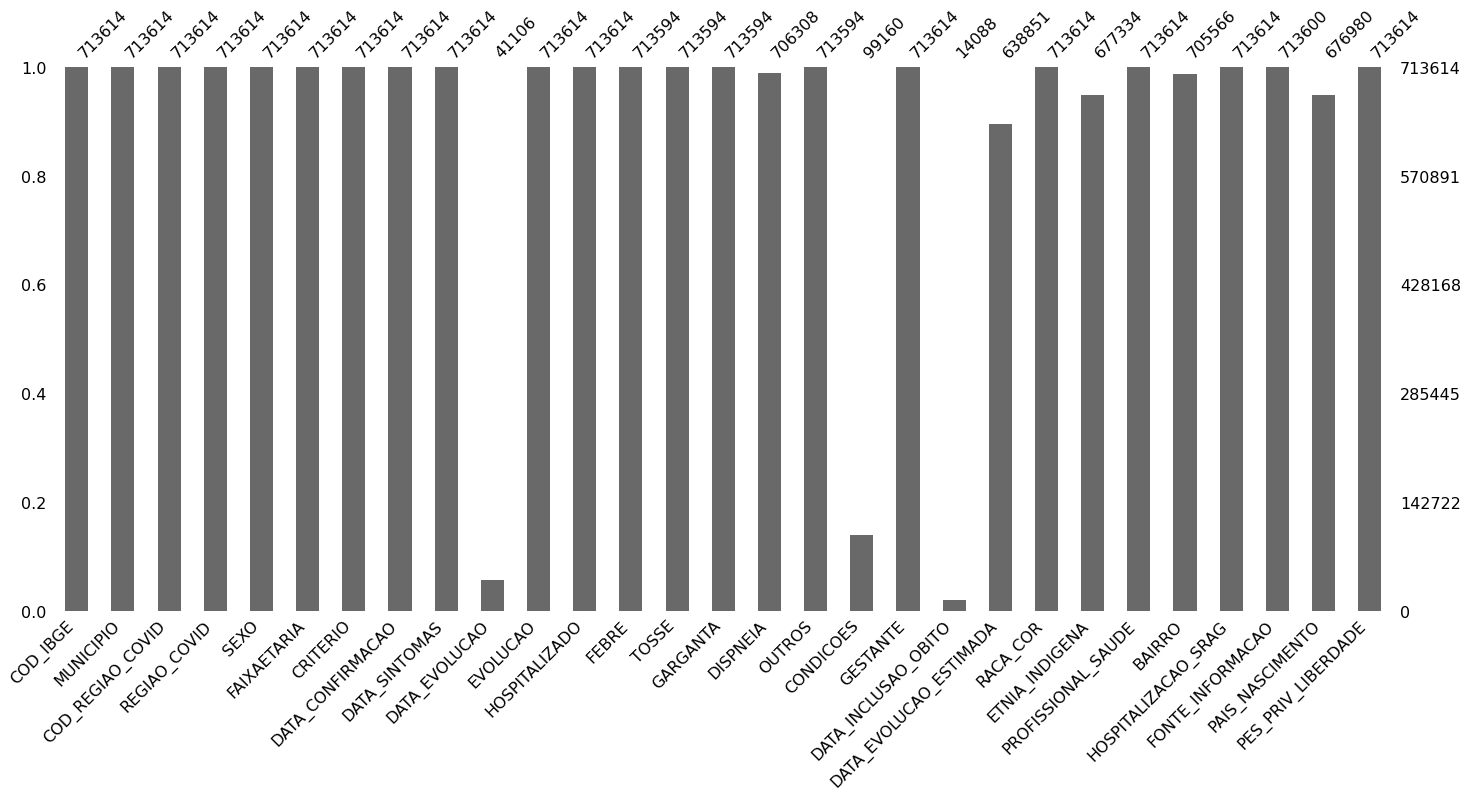

In [10]:
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False) * 100)
msno.bar(df);

Dispneia possui 1.02% de dados faltantes, febre e tosse possuem apenas 0.0028% faltante. O que nos permite remover esses registros, devido a baixa proporção, o que não impactaria no conjunto geral.

Dentre o top 5 de dados faltantes: 

 - DATA_INCLUSAO_OBITO       98.02%
 - DATA_EVOLUCAO             94.23%
 - CONDICOES                 86.10%
 - DATA_EVOLUCAO_ESTIMADA    10.47%
 - PAIS_NASCIMENTO            5.13%
 
dentre esses, apenas as condições nos interessam, e conta apenas como extra. O restante das variáveis serão removidas, pois não agregam informação para o nosso objetivo.

#### 2.6 Valores possíveis para campos categóricos

In [11]:
# valores únicos
print("\nVALORES ÚNICOS:")
print(df.nunique().sort_values())


VALORES ÚNICOS:
GARGANTA                      2
HOSPITALIZACAO_SRAG           2
GESTANTE                      2
OUTROS                        2
DISPNEIA                      2
TOSSE                         2
FEBRE                         2
HOSPITALIZADO                 2
PES_PRIV_LIBERDADE            2
SEXO                          2
FONTE_INFORMACAO              3
PROFISSIONAL_SAUDE            3
EVOLUCAO                      4
RACA_COR                      6
CRITERIO                      8
FAIXAETARIA                  12
COD_REGIAO_COVID             21
REGIAO_COVID                 21
ETNIA_INDIGENA               23
PAIS_NASCIMENTO              75
DATA_INCLUSAO_OBITO         341
DATA_EVOLUCAO               357
DATA_EVOLUCAO_ESTIMADA      363
DATA_CONFIRMACAO            373
DATA_SINTOMAS               376
MUNICIPIO                   497
COD_IBGE                    497
CONDICOES                   949
BAIRRO                    23993
dtype: int64


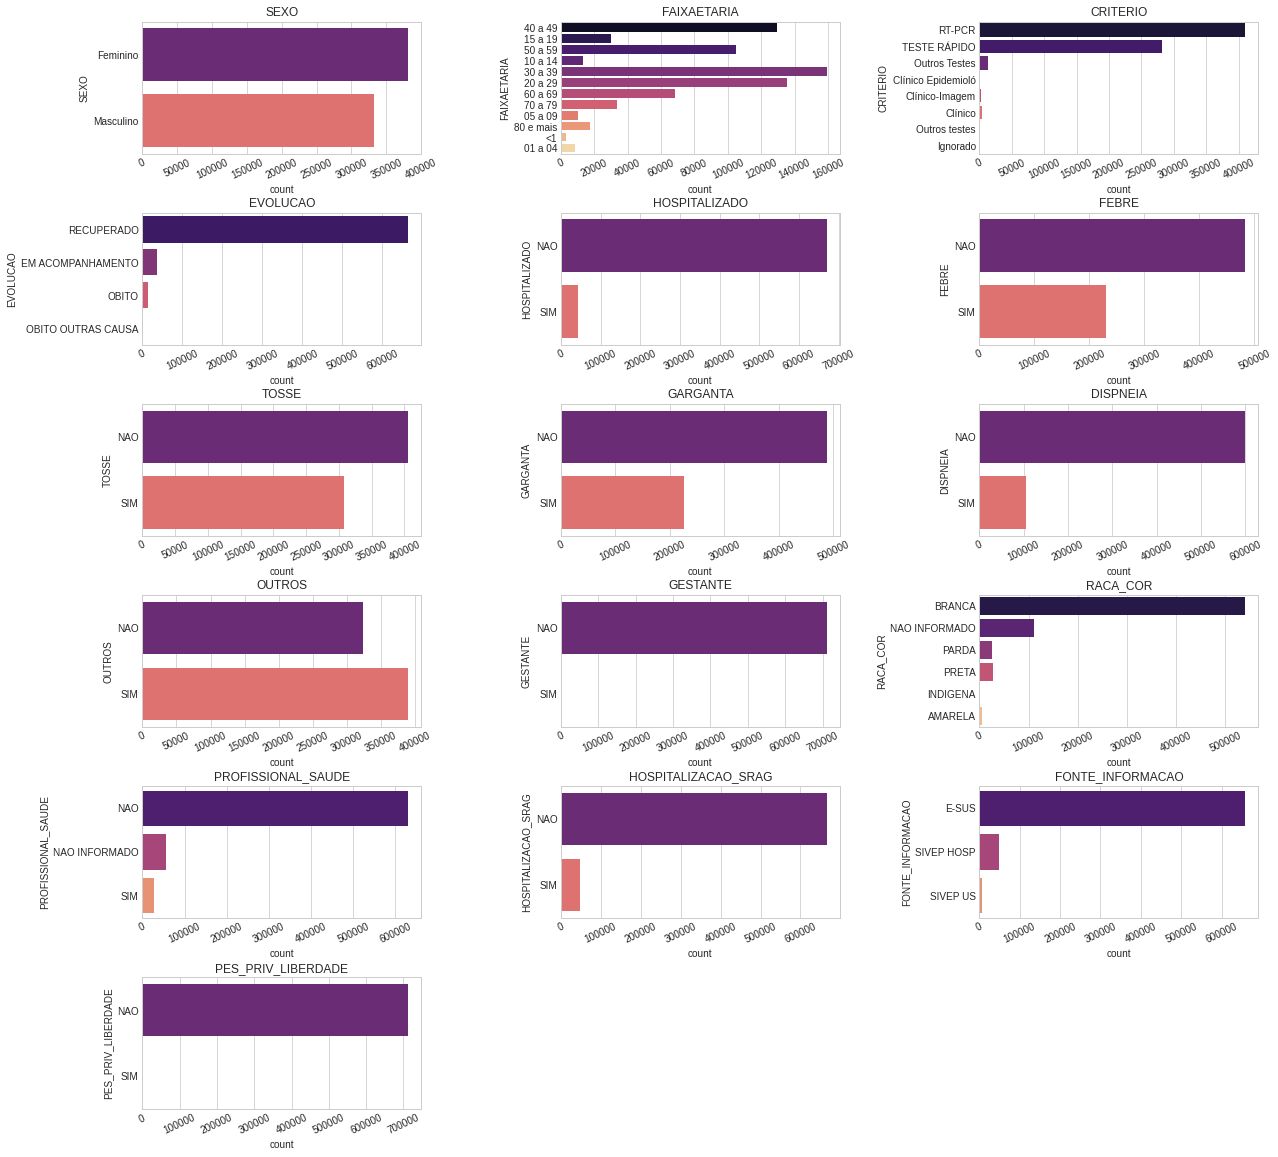

In [12]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset, palette="magma")
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df.drop(['BAIRRO', 'CONDICOES', 'COD_IBGE', 'MUNICIPIO', 'DATA_SINTOMAS', 
                           'DATA_CONFIRMACAO', 'DATA_EVOLUCAO_ESTIMADA',
                           'DATA_INCLUSAO_OBITO', 'PAIS_NASCIMENTO', 'DATA_EVOLUCAO', 'COD_REGIAO_COVID', 
                           'REGIAO_COVID', 'ETNIA_INDIGENA'], axis=1), 
                          cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

#### 2.7 Proporção de óbitos por covid no conjunto de dados

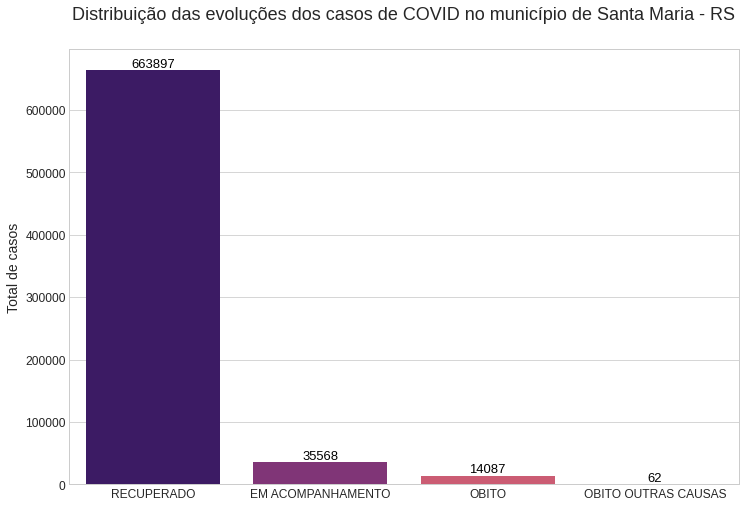

In [13]:
plt.rc('figure', figsize=(12, 8))
ax = sns.countplot(x='EVOLUCAO', data=df, palette='magma')

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2 # divide por 2 pra ficar no meio
            _y = p.get_y() + p.get_height() + 5000 # mais 5000 pra n ficar colado na altura da barra
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=13, color='black',) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
show_values_on_bars(ax)

ax.set_title('Distribuição das evoluções dos casos de COVID no município de Santa Maria - RS', fontsize=18, pad=30);
ax.set_ylabel('Total de casos', fontsize=14)
ax.set_xlabel('')

ax.tick_params(axis='both', which='major', labelsize=12)

In [15]:
print("Proporção entre casos no Dataset:")
print(df['EVOLUCAO'].value_counts() / df.shape[0] * 100)


Proporção entre casos no Dataset:
RECUPERADO             93.033068
EM ACOMPANHAMENTO       4.984207
OBITO                   1.974036
OBITO OUTRAS CAUSAS     0.008688
Name: EVOLUCAO, dtype: float64


In [16]:
df_obitos = df[df['EVOLUCAO'] == 'OBITO']

In [28]:
for row in df_obitos.drop(['BAIRRO', 'CONDICOES', 'COD_IBGE', 'MUNICIPIO', 'DATA_SINTOMAS', 
                           'DATA_CONFIRMACAO', 'DATA_EVOLUCAO_ESTIMADA',
                           'DATA_INCLUSAO_OBITO', 'PAIS_NASCIMENTO', 'DATA_EVOLUCAO', 'COD_REGIAO_COVID', 
                           'REGIAO_COVID', 'ETNIA_INDIGENA', 'EVOLUCAO'], axis=1).columns:
    print('------------------------------')
    print(row)
    c = df_obitos[row].value_counts(dropna=False)
    p = df_obitos[row].value_counts(dropna=False, normalize=True) * 100
    print(pd.concat([c,p], axis=1, keys=['Total', 'Porcentagem']))
    print('------------------------------')
    

------------------------------
SEXO
           Total  Porcentagem
Masculino   7683    54.539646
Feminino    6404    45.460354
------------------------------
------------------------------
FAIXAETARIA
           Total  Porcentagem
80 e mais   4112    29.190033
70 a 79     3994    28.352382
60 a 69     3215    22.822460
50 a 59     1553    11.024349
40 a 49      755     5.359551
30 a 39      325     2.307092
20 a 29       98     0.695677
15 a 19       20     0.141975
01 a 04        5     0.035494
<1             4     0.028395
10 a 14        3     0.021296
05 a 09        3     0.021296
------------------------------
------------------------------
CRITERIO
                        Total  Porcentagem
RT-PCR                  12211    86.682757
TESTE RÁPIDO             1402     9.952438
Clínico-Imagem            342     2.427770
Outros Testes              48     0.340740
Outros testes              41     0.291048
Clínico Epidemiológico     33     0.234259
Clínico                     8     0.05

#### 2.8 Conclusão da exploração dos dados

Os dados parecem já estar relativamente limpos, com exceção do campo `CONDICOES` de onde pode-se extrair mais informações. No geral, as informações que nos interessam são preenchidas apenas com "SIM" ou "NÃO", que são os campos de sintomas, como `FEBRE` (embora existam campos com NAO, sem acento). E o campo `EVOLUCAO`, que é a nossa variavel preditora. A faixa etária já está bem definida, e pode-se apenas definir a ordem de precedência de cada categoria.

Dentre o conjunto de dados, 93% dos dados são Recuperados, e apenas 1.97% é Óbito por COVID-19. Temos um problema de desbalanceamento, e precisamos tratá-lo posteriormente.

___